In [2]:
import json
import pandas as pd
import pystac
import rasterio
from datetime import datetime
from pystac import Catalog, Collection, CatalogType
from rasterio import features, warp

In [1]:
from pathlib import Path
folder = Path.cwd() / 'ca_22_parts'
tiffs = list(folder.rglob('*.tif'))
tiffs

[WindowsPath('C:/Users/Admin/Documents/landfire research/ca_22_parts/california_2022_part_0_0.tif'),
 WindowsPath('C:/Users/Admin/Documents/landfire research/ca_22_parts/california_2022_part_0_10000.tif'),
 WindowsPath('C:/Users/Admin/Documents/landfire research/ca_22_parts/california_2022_part_0_20000.tif'),
 WindowsPath('C:/Users/Admin/Documents/landfire research/ca_22_parts/california_2022_part_0_30000.tif'),
 WindowsPath('C:/Users/Admin/Documents/landfire research/ca_22_parts/california_2022_part_0_40000.tif'),
 WindowsPath('C:/Users/Admin/Documents/landfire research/ca_22_parts/california_2022_part_10000_0.tif'),
 WindowsPath('C:/Users/Admin/Documents/landfire research/ca_22_parts/california_2022_part_10000_10000.tif'),
 WindowsPath('C:/Users/Admin/Documents/landfire research/ca_22_parts/california_2022_part_10000_20000.tif'),
 WindowsPath('C:/Users/Admin/Documents/landfire research/ca_22_parts/california_2022_part_10000_30000.tif'),
 WindowsPath('C:/Users/Admin/Documents/landfire

In [25]:
stac_items = []
for source_img in tiffs:
    with rasterio.open(source_img) as src:
        bounds_native = src.bounds
        native_crs = src.crs

        geom_native = {
            'type': 'Polygon',
            'coordinates': [
                [
                    [bounds_native.left, bounds_native.top],
                    [bounds_native.left, bounds_native.bottom],
                    [bounds_native.right, bounds_native.bottom],
                    [bounds_native.right, bounds_native.top],
                    [bounds_native.left, bounds_native.top]
                ]
            ]
        }

        geom_4326 = warp.transform_geom(
            native_crs,
            'EPSG:4326',
            geom_native,
        )

        # Get the bounds in EPSG:4326
        bounds_4326 = rasterio.features.bounds(geom_4326)
        dt = pd.to_datetime('010122')
        item_id = source_img.name.split('.')[0]

        item = pystac.Item(
            id=item_id,
            geometry=geom_4326,
            bbox=bounds_4326,
            datetime=dt,
            properties={
                'platform': 'Landsat',
            }
        )

        for fuel_type in ['NB', 'GR', 'GS', 'SH', 'SB', 'TU', 'TL']:
            asset = pystac.Asset(
                href=str(f'https://actionengine-public.s3.us-east-2.amazonaws.com/california_2022_tiles/{source_img.name}_{fuel_type}_zoom.tif'),
                media_type=pystac.MediaType.COG,
                roles=[fuel_type]
                )

            item.add_asset(fuel_type, asset)
        stac_items.append(item)

In [33]:
print(json.dumps(stac_items[1].to_dict(), indent=4))

{
    "type": "Feature",
    "stac_version": "1.0.0",
    "id": "california_2022_part_0_10000",
    "properties": {
        "platform": "Landsat",
        "datetime": "2022-01-01T00:00:00Z"
    },
    "geometry": {
        "type": "Polygon",
        "coordinates": [
            [
                [
                    -124.02891861902339,
                    39.26590116734393
                ],
                [
                    -123.04359345936527,
                    36.70037367834306
                ],
                [
                    -119.75867978481247,
                    37.40768014574026
                ],
                [
                    -120.63585938995406,
                    39.99841067559046
                ],
                [
                    -124.02891861902339,
                    39.26590116734393
                ]
            ]
        ]
    },
    "links": [],
    "assets": {
        "NB": {
            "href": "https://actionengine-public.s3.us-east-

In [39]:
from shapely.ops import unary_union
import matplotlib.pyplot as plt 
from shapely.geometry import shape

def get_spatial_extent(polygons):
    
    # Plot of polygons overlay
    plt.figure(figsize=(14, 8))
    for polygon in polygons:
        plt.plot(*shape(polygon).exterior.xy)

    # Returns a union of the two geojson polygons for each item
    unioned_geometry = unary_union(polygons)

    # Plot the unified polygon
    x, y = shape(unioned_geometry).exterior.xy
    plt.figure(figsize=(14,8))
    plt.fill(x, y, alpha=0.5, facecolor='none', edgecolor='purple', linewidth=7)
    plt.show()
    
    # Set the bbox to be the bounds of the unified polygon and return the spatial extent of the collection
    return pystac.SpatialExtent(bboxes=[unioned_geometry.bounds])



def get_temporal_extent(startime, endtime):
    time_interval = [startime, endtime]
    temporal_extent = pystac.TemporalExtent(intervals=[time_interval])
    return temporal_extent



def create_full_extent(stac_item_list):
    polygons = []
    datetimes = []
    
    for index, stac_item in enumerate(stac_item_list):
        # geometry = stac_item.geometry
        polygons.append(shape(stac_item.geometry))
        # datetime = pd.to_datetime(stac_item.properties['datetime'])
        # datetimes.append(datetime)
        
    # Get the spatial extent
    spatial_extent = get_spatial_extent(polygons)
    
    # Get temporal extent
    # temporal_extent = get_temporal_extent(min(datetimes), max(datetimes))
    temporal_extent = pystac.collection.TemporalExtent.from_dict({'interval': [['2022-01-01T00:00:00Z', '2022-01-01T00:00:00Z']]})
    collection_extent = pystac.Extent(spatial=spatial_extent, temporal=temporal_extent)
    
    return collection_extent

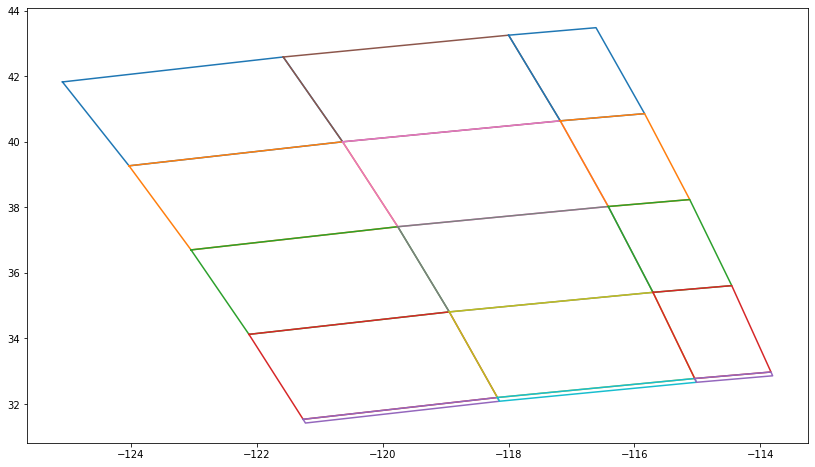

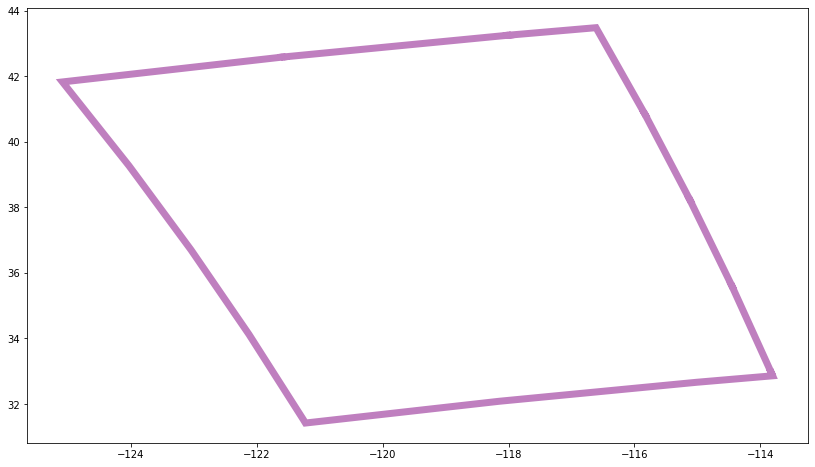

In [40]:
extent = create_full_extent(stac_items)

In [41]:
print(json.dumps(extent.to_dict(), indent=4))

{
    "spatial": {
        "bbox": [
            [
                -125.0863037339109,
                31.419048051278583,
                -113.80389292372254,
                43.47953263024537
            ]
        ]
    },
    "temporal": {
        "interval": [
            [
                "2022-01-01T00:00:00Z",
                "2022-01-01T00:00:00Z"
            ]
        ]
    }
}


In [43]:
stac_path = Path.cwd() / 'stac_ca/ca_2022'
collection_2022_path = stac_path / 'collection.json'

collection_2022 = pystac.Collection(
    id='california_landfire_2022',
    description='Fuel types California map 2022 from Landfire',
    extent=extent,
    href=str(collection_2022_path),
    catalog_type=pystac.CatalogType.SELF_CONTAINED
)

In [44]:
collection_2022.add_items(stac_items)

In [46]:
print(json.dumps(collection_2022.to_dict(), indent=4))

{
    "type": "Collection",
    "id": "california_landfire_2022",
    "stac_version": "1.0.0",
    "description": "Fuel types California map 2022 from Landfire",
    "links": [
        {
            "rel": "root",
            "href": ".\\collection.json",
            "type": "application/json"
        },
        {
            "rel": "self",
            "href": "C:\\Users\\Admin\\Documents\\landfire research\\stac_ca\\ca_2022\\collection.json",
            "type": "application/json"
        },
        {
            "rel": "item",
            "href": ".\\california_2022_part_0_0\\california_2022_part_0_0.json",
            "type": "application/json"
        },
        {
            "rel": "item",
            "href": ".\\california_2022_part_0_10000\\california_2022_part_0_10000.json",
            "type": "application/json"
        },
        {
            "rel": "item",
            "href": ".\\california_2022_part_0_20000\\california_2022_part_0_20000.json",
            "type": "applicat

In [48]:
collection_2022.make_all_asset_hrefs_relative()
collection_2022.normalize_and_save(str(stac_path))

In [49]:
stac_path = Path.cwd() / 'stac_ca'
collection_path = stac_path / 'collection.json'

collection = pystac.Collection(
    id='california_landfire',
    description='Fuel types California map from Landfire',
    extent=extent,
    href=str(collection_path),
    catalog_type=pystac.CatalogType.SELF_CONTAINED
)

In [51]:
collection.add_child(collection_2022)

In [52]:
print(json.dumps(collection.to_dict(), indent=4))

{
    "type": "Collection",
    "id": "california_landfire",
    "stac_version": "1.0.0",
    "description": "Fuel types California map from Landfire",
    "links": [
        {
            "rel": "root",
            "href": ".\\collection.json",
            "type": "application/json"
        },
        {
            "rel": "self",
            "href": "C:\\Users\\Admin\\Documents\\landfire research\\stac_ca\\collection.json",
            "type": "application/json"
        },
        {
            "rel": "child",
            "href": ".\\california_landfire_2022\\collection.json",
            "type": "application/json"
        }
    ],
    "stac_extensions": [],
    "extent": {
        "spatial": {
            "bbox": [
                [
                    -125.0863037339109,
                    31.419048051278583,
                    -113.80389292372254,
                    43.47953263024537
                ]
            ]
        },
        "temporal": {
            "interval": [
     

In [53]:
collection.make_all_asset_hrefs_relative()
collection.normalize_and_save(str(stac_path))

In [55]:
import os

In [57]:
for dirname in os.listdir('stac_ca/california_landfire_2022'):
    stac_ca/california_landfire_2022/

['california_2022_part_0_0',
 'california_2022_part_0_10000',
 'california_2022_part_0_20000',
 'california_2022_part_0_30000',
 'california_2022_part_0_40000',
 'california_2022_part_10000_0',
 'california_2022_part_10000_10000',
 'california_2022_part_10000_20000',
 'california_2022_part_10000_30000',
 'california_2022_part_10000_40000',
 'california_2022_part_20000_0',
 'california_2022_part_20000_10000',
 'california_2022_part_20000_20000',
 'california_2022_part_20000_30000',
 'california_2022_part_20000_40000',
 'collection.json']

In [63]:
!python ingest_ca.py https://api.stac.k8s.actionengine.com/

Traceback (most recent call last):
  File "C:\Users\Admin\Documents\landfire research\ingest_ca.py", line 60, in <module>
    ingest_ca_data()
  File "C:\Users\Admin\Documents\landfire research\ingest_ca.py", line 46, in ingest_ca_data
    with open(f'stac_ca/california_landfire_2022/{dirname}/{dirname}.json') as f:
FileNotFoundError: [Errno 2] No such file or directory: 'stac_ca/california_landfire_2022/collection.json/collection.json.json'
